In [ ]:
import numpy as np 
import pandas as pd
import tensorflow as tf

from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.models import Sequential
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping

In [ ]:
print(tf.__version__)

2.8.2


## Explore the dataset

The dataset is provided in a csv file. 

Each row of this file contains the following values separated by commas:

- user: the user that tweeted

- text: the text of the tweet


Take a look at the first two examples:

In [ ]:
data = pd.read_csv('/content/Macam Infeksi Gigi.xlsx - DataTwit.csv', usecols=['Kategori', 'Gejala'])
data.dropna(inplace=True)
data.head()

FileNotFoundError: ignored

In [ ]:
data.Kategori.value_counts()

e    67
c    62
b    56
a    47
f    47
d    46
Name: Kategori, dtype: int64

In [ ]:
data.count()

Kategori    325
Gejala      325
dtype: int64

##Encoding data, converting data in categories into numerical

In [ ]:
num_of_categories = 45000
shuffled = data.reindex(np.random.permutation(data.index))
a = shuffled[shuffled['Kategori'] == 'a'][:num_of_categories]
b = shuffled[shuffled['Kategori'] == 'b'][:num_of_categories]
c = shuffled[shuffled['Kategori'] == 'c'][:num_of_categories]
d = shuffled[shuffled['Kategori'] == 'd'][:num_of_categories]
e = shuffled[shuffled['Kategori'] == 'e'][:num_of_categories]
f = shuffled[shuffled['Kategori'] == 'f'][:num_of_categories]


concated = pd.concat([a,b,c,d,e,f], ignore_index=True)
#Shuffle the dataset
concated = concated.reindex(np.random.permutation(concated.index))
concated['LABEL'] = 0

In [ ]:
#One-hot encode the lab
concated.loc[concated['Kategori'] == 'a', 'LABEL'] = 0
concated.loc[concated['Kategori'] == 'b', 'LABEL'] = 1
concated.loc[concated['Kategori'] == 'c', 'LABEL'] = 2
concated.loc[concated['Kategori'] == 'd', 'LABEL'] = 3
concated.loc[concated['Kategori'] == 'e', 'LABEL'] = 4
concated.loc[concated['Kategori'] == 'f', 'LABEL'] = 5


print(concated['LABEL'][:10])
labels = to_categorical(concated['LABEL'], num_classes=6)
print(labels[:10])
if 'Kategori' in concated.keys():
    concated.drop(['Kategori'], axis=1)
'''
 [1. 0. 0. 0. 0. 0.] a
 [0. 1. 0. 0. 0. 0.] b
 [0. 0. 1. 0. 0. 0.] c
 [0. 0. 0. 1. 0. 0.] d
 [0. 0. 0. 0. 1. 0.] e
 [0. 0. 0. 0. 0. 1.] f
'''

271    4
295    5
156    2
224    4
64     1
108    2
241    4
96     1
157    2
33     0
Name: LABEL, dtype: int64
[[0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]]


'\n [1. 0. 0. 0. 0. 0.] a\n [0. 1. 0. 0. 0. 0.] b\n [0. 0. 1. 0. 0. 0.] c\n [0. 0. 0. 1. 0. 0.] d\n [0. 0. 0. 0. 1. 0.] e\n [0. 0. 0. 0. 0. 1.] f\n'

## Tokenization - Sequences and padding

Now that you have sets for training and validation it is time for you to begin the tokenization process.

Begin by completing the `fit_tokenizer` function below. This function should return a [Tokenizer](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer) that has been fitted to the training sentences.

In [ ]:
n_most_common_words = 8000
max_len = 130
tokenizer = Tokenizer(num_words=n_most_common_words, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(concated['Gejala'].values)
sequences = tokenizer.texts_to_sequences(concated['Gejala'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

X = pad_sequences(sequences, maxlen=max_len)

Found 705 unique tokens.


## Split data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X , labels, test_size=0.25, random_state=21)

In [ ]:
X_test

array([[  0,   0,   0, ..., 147, 634, 635],
       [  0,   0,   0, ...,  31,  11,  33],
       [  0,   0,   0, ...,  14, 195, 688],
       ...,
       [  0,   0,   0, ...,   8,  11,  10],
       [  0,   0,   0, ..., 116,  89, 417],
       [  0,   0,   0, ...,   3,  14,  10]], dtype=int32)

In [ ]:
epochs = 100
emb_dim = 128
batch_size = 64
labels[:6]

array([[0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.]], dtype=float32)

# Define a model 

In [ ]:
print((X_train.shape, y_train.shape, X_test.shape, y_test.shape))

model = Sequential()
model.add(Embedding(n_most_common_words, emb_dim, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.3))
model.add(LSTM(100, dropout=0.3, recurrent_dropout=0.3))
#model.add(Dense(64, activation='relu'))
model.add(Dense(6, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
print(model.summary())


((243, 130), (243, 6), (82, 130), (82, 6))
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 130, 128)          1024000   
                                                                 
 spatial_dropout1d (SpatialD  (None, 130, 128)         0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 100)               91600     
                                                                 
 dense (Dense)               (None, 6)                 606       
                                                                 
Total params: 1,116,206
Trainable params: 1,116,206
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.2,
                    )

Epoch 1/100
4/4 [==============================] - 5s 500ms/step - loss: 1.7928 - acc: 0.1443 - val_loss: 1.7837 - val_acc: 0.2857
Epoch 2/100
4/4 [==============================] - 1s 325ms/step - loss: 1.7768 - acc: 0.2990 - val_loss: 1.7755 - val_acc: 0.2245
Epoch 3/100
4/4 [==============================] - 1s 321ms/step - loss: 1.7618 - acc: 0.2474 - val_loss: 1.7740 - val_acc: 0.1837
Epoch 4/100
4/4 [==============================] - 1s 326ms/step - loss: 1.7454 - acc: 0.1959 - val_loss: 1.7854 - val_acc: 0.1837
Epoch 5/100
4/4 [==============================] - 1s 327ms/step - loss: 1.7520 - acc: 0.1907 - val_loss: 1.7886 - val_acc: 0.1837
Epoch 6/100
4/4 [==============================] - 1s 325ms/step - loss: 1.7342 - acc: 0.2165 - val_loss: 1.7679 - val_acc: 0.2245
Epoch 7/100
4/4 [==============================] - 1s 323ms/step - loss: 1.7094 - acc: 0.2887 - val_loss: 1.7631 - val_acc: 0.2449
Epoch 8/100
4/4 [==============================] - 1s 326ms/step - loss: 1.7032 - a

In [ ]:
accr = model.evaluate(X_test,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

3/3 [==============================] - 0s 32ms/step - loss: 1.6730 - acc: 0.5976
Test set
  Loss: 1.673
  Accuracy: 0.598


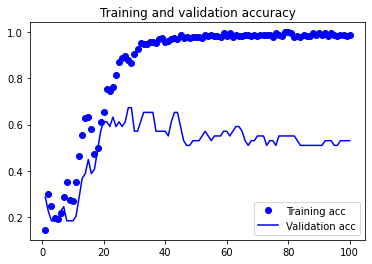

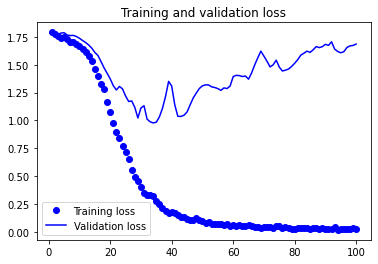

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

##Test the Model

In [ ]:
def test_pred(text):
  input = []
  input.append(text)
  seq = tokenizer.texts_to_sequences(input)
  padded = pad_sequences(seq, maxlen=max_len)
  pred = model.predict(padded)
  labels = ['Karies Gigi', 'karang Gigi', 'Abses Gigi', 'Radang Gusi','Bukan Gejala Penyakit','Sariawan']
  print(pred, labels[np.argmax(pred)])

In [ ]:
test_pred('ada yg  bolong pada gigiku')

[[9.8888075e-01 7.4397452e-04 7.7258926e-03 1.7273164e-04 5.8260141e-04
  1.8941655e-03]] Karies Gigi


In [ ]:
test_pred('ada lapisan kasar dan keras di garis gusi saya')

[[1.7589445e-08 9.9983764e-01 8.2612434e-07 1.4592528e-04 2.0523443e-07
  1.5401989e-05]] karang Gigi


In [ ]:
test_pred('jika memakan sesuatu yang dingin gigiku terasa nyeri')

[[4.1645279e-05 4.4641027e-01 1.4635378e-03 5.5199671e-01 3.8595084e-05
  4.9248472e-05]] Radang Gusi


In [ ]:
test_pred('Ujung gusi mengalami pengikisan')

[[1.2176018e-05 1.7308517e-03 1.4676027e-04 9.9799323e-01 1.0772504e-04
  9.3314575e-06]] Radang Gusi


In [ ]:
test_pred('ngantuk')

[[7.1196300e-03 1.4771847e-03 3.2830036e-03 1.3538724e-03 9.8600686e-01
  7.5948465e-04]] Bukan Gejala Penyakit


In [ ]:
test_pred('ada luka berbentuk bulat berwarna putih')

[[3.3239743e-05 3.5281526e-04 1.4495502e-04 1.5997647e-04 2.3650171e-05
  9.9928540e-01]] Sariawan


In [ ]:
test_pred('bengkak di gigi')

[[0.09466854 0.00637211 0.89006215 0.00335645 0.0044903  0.00105038]] Abses Gigi


##Save Model

In [ ]:
model = tf.keras

# Exporting to TFLite

You will now save the model to TFLite. We should note, that you will probably see some warning messages when running the code below. These warnings have to do with software updates and should not cause any errors or prevent your code from running. 

In [ ]:
import pickle 
pickle.dump(model,open('model.pkl','wb'))

INFO:tensorflow:Assets written to: ram://02171e19-513e-4084-a6d2-e3d4932babca/assets


INFO:tensorflow:Assets written to: ram://02171e19-513e-4084-a6d2-e3d4932babca/assets


In [ ]:
from flask import Flask,request,jsonify
import numpy as np
import pickle
model = pickle.load(open('model.pkl','rb'))
app = Flask(__name__)
@app.route('/')
def index():
    return "Hello world"
@app.route('/predict',methods=['POST'])
def test_pred(text):
    input = []
    input.append(text)
    seq = tokenizer.texts_to_sequences(input)
    padded = pad_sequences(seq, maxlen=max_len)
    pred = model.predict(padded)
    labels = ['Karies Gigi', 'karang Gigi', 'Abses Gigi', 'Radang Gusi','Bukan Gejala Penyakit','Sariawan']
    print(pred, labels[np.argmax(pred)])
if __name__ == '__main__':
    app.run(debug=True)

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on


INFO:werkzeug: * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
INFO:werkzeug: * Restarting with stat


SystemExit: ignored

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2890: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


##=========================================

In [ ]:
# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model shuold be saved to HDF5.
model.save('my_model.h5') 

In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir='/content/saved_model/1', signature_keys=['serving_default'])
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.experimental_new_converter = True

tflite_model = converter.convert()

# Save the model.
with open('model_1.tflite', 'wb') as f:
  f.write(tflite_model)

from google.colab import files
files.download('model_1.tflite')

ConverterError: ignored

In [ ]:
tflite_model = tf.keras.models.load_model('my_model.h5')
converter = tf.lite.TFLiteConverter.from_keras_model(tflite_model)
tflite_save = converter.convert()
open("generated.tflite", "wb").write(tflite_save)

INFO:tensorflow:Assets written to: /tmp/tmpprzn8dwr/assets


INFO:tensorflow:Assets written to: /tmp/tmpprzn8dwr/assets


ConverterError: ignored

In [ ]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
converter._experimental_lower_tensor_list_ops = False

tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

from google.colab import files
files.download('model.tflite')

INFO:tensorflow:Assets written to: /tmp/tmp_qiyxj70/assets


INFO:tensorflow:Assets written to: /tmp/tmp_qiyxj70/assets


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# EXERCISE: Use the tf.saved_model API to save your model in the SavedModel format. 
export_dir = 'saved_model/1'

# YOUR CODE HERE
tf.saved_model.save(model,export_dir=export_dir)

INFO:tensorflow:Assets written to: saved_model/1/assets


INFO:tensorflow:Assets written to: saved_model/1/assets


In [ ]:
# EXERCISE: Use the TFLiteConverter SavedModel API to initialize the converter

converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)

# Set the optimzations
converter.optimizations = [optimization]

# Invoke the converter to finally generate the TFLite model
tflite_model = converter.convert();

NameError: ignored

In [ ]:
import os
import zipfile

zf = zipfile.ZipFile("myzipfile.zip", "w")
for dirname, subdirs, files in os.walk("saved_model"):
    zf.write(dirname)
    for filename in files:
        zf.write(os.path.join(dirname, filename))
zf.close()